In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from functools import partial
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group
DIR = 'PATH/TO/YOUR/DATA'

description = pd.read_csv(('HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv('application_train.csv')
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')

In [2]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [3]:
pos_cash_balance.shape

(10001358, 8)

In [4]:
POS_CASH_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['MONTHS_BALANCE',
                   'SK_DPD',
                   'SK_DPD_DEF'
                   ]:
        POS_CASH_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
POS_CASH_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], POS_CASH_BALANCE_AGGREGATION_RECIPIES)]

In [5]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(POS_CASH_BALANCE_AGGREGATION_RECIPIES):
    group_object = pos_cash_balance.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [6]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_min_SK_DPD_DEF,SK_ID_CURR_max_MONTHS_BALANCE,SK_ID_CURR_max_SK_DPD,SK_ID_CURR_max_SK_DPD_DEF,SK_ID_CURR_sum_MONTHS_BALANCE,SK_ID_CURR_sum_SK_DPD,SK_ID_CURR_sum_SK_DPD_DEF,SK_ID_CURR_var_MONTHS_BALANCE,SK_ID_CURR_var_SK_DPD,SK_ID_CURR_var_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,-1.0,0.0,0.0,-190.0,0.0,0.0,31.666667,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-18.0,0.0,0.0,-1226.0,0.0,0.0,607.137566,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-24.0,0.0,0.0,-102.0,0.0,0.0,1.666667,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-1.0,0.0,0.0,-202.0,0.0,0.0,36.947619,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1.0,0.0,0.0,-2220.0,0.0,0.0,510.265734,0.0,0.0


In [7]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [8]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                            1.000000
SK_ID_CURR_min_MONTHS_BALANCE     0.055307
SK_ID_CURR_var_MONTHS_BALANCE     0.048760
SK_ID_CURR_sum_MONTHS_BALANCE     0.040570
SK_ID_CURR_mean_MONTHS_BALANCE    0.034543
SK_ID_CURR_max_SK_DPD_DEF         0.009580
SK_ID_CURR_mean_SK_DPD_DEF        0.006496
SK_ID_CURR_min_SK_DPD             0.005444
SK_ID_CURR_mean_SK_DPD            0.005436
SK_ID_CURR_sum_SK_DPD_DEF         0.004950
SK_ID_CURR_max_SK_DPD             0.004763
SK_ID_CURR_sum_SK_DPD             0.004740
SK_ID_CURR_min_SK_DPD_DEF         0.004702
SK_ID_CURR_max_MONTHS_BALANCE     0.004321
SK_ID_CURR_var_SK_DPD_DEF         0.004076
SK_ID_CURR_var_SK_DPD             0.003361
Name: TARGET, dtype: float64

In [9]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})

In [10]:
group_object = pos_cash_balance.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
group_object.rename(index=str,
                    columns={'CNT_INSTALMENT_FUTURE': 'pos_cash_remaining_installments'},
                    inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,pos_cash_remaining_installments
0,182943,5.0
1,367990,4.0
2,397406,0.0
3,269225,24.0
4,334279,2.0


In [11]:
pos_cash_balance['is_contract_status_completed'] = pos_cash_balance['NAME_CONTRACT_STATUS'] == 'Completed'
group_object = pos_cash_balance.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
group_object.rename(index=str,
                    columns={'is_contract_status_completed': 'pos_cash_completed_contracts'},
                    inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [12]:
X = application.merge(features, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')
X = X[features.columns.tolist()+['TARGET']]

In [13]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
credit_eng = X[engineered_numerical_columns + ['TARGET']]
credit_eng_corr = abs(credit_eng.corr())

In [14]:
credit_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                             1.000000
pos_cash_completed_contracts       0.019547
pos_cash_remaining_installments    0.015371
Name: TARGET, dtype: float64

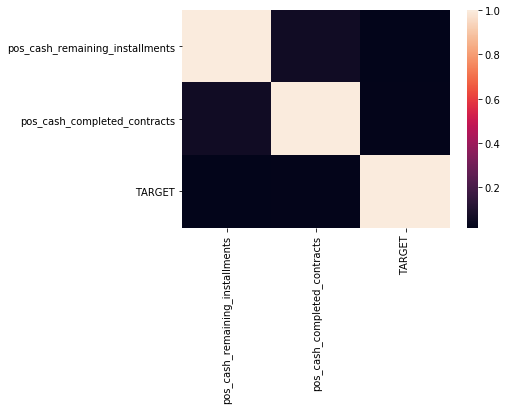

In [15]:
sns.heatmap(credit_eng_corr, 
            xticklabels=credit_eng_corr.columns,
            yticklabels=credit_eng_corr.columns)

In [16]:
features.head()

,SK_ID_CURR,pos_cash_remaining_installments,pos_cash_completed_contracts
0,182943,5.0,1.0
1,367990,4.0,2.0
2,397406,0.0,6.0
3,269225,24.0,5.0
4,334279,2.0,4.0


In [17]:
# pos_cash_balance['pos_cash_paid_late'] = (pos_cash_balance['SK_DPD'] > 0).astype(int)
# pos_cash_balance['pos_cash_paid_late_with_tolerance'] = (pos_cash_balance['SK_DPD_DEF'] > 0).astype(int)
# groupby = pos_cash_balance.groupby(['SK_ID_CURR'])

In [18]:
# def last_k_installment_features(gr, periods):
#     gr_ = gr.copy()

#     features = {}
#     for period in periods:
#         if period > 10e10:
#             period_name = 'all_installment_'
#             gr_period = gr_.copy()
#         else:
#             period_name = 'last_{}_'.format(period)
#             gr_period = gr_[gr_['MONTHS_BALANCE'] >= (-1) * period]

#         features = add_features_in_group(features, gr_period, 'pos_cash_paid_late',
#                                              ['count', 'mean'],
#                                              period_name)
#         features = add_features_in_group(features, gr_period, 'pos_cash_paid_late_with_tolerance',
#                                              ['count', 'mean'],
#                                              period_name)
#         features = add_features_in_group(features, gr_period, 'SK_DPD',
#                                              ['sum', 'mean', 'max', 'min', 'median'],
#                                              period_name)
#         features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
#                                              ['sum', 'mean', 'max', 'min','median'],
#                                              period_name)
#     return features

In [19]:
# features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
# func = partial(last_k_installment_features, periods=[6, 12, 24, 60, 10e16])
# g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
# features = features.merge(g, on='SK_ID_CURR', how='left')

In [20]:
features.head(15)

,SK_ID_CURR,pos_cash_remaining_installments,pos_cash_completed_contracts
0,182943,5.0,1.0
1,367990,4.0,2.0
2,397406,0.0,6.0
3,269225,24.0,5.0
4,334279,2.0,4.0
5,342166,5.0,3.0
6,204376,19.0,3.0
7,153211,25.0,0.0
8,112740,11.0,7.0
9,274851,6.0,6.0


In [21]:
features.tail(15)

,SK_ID_CURR,pos_cash_remaining_installments,pos_cash_completed_contracts
337237,445665,6.0,0.0
337238,105063,10.0,0.0
337239,169377,12.0,0.0
337240,224555,12.0,0.0
337241,281029,12.0,0.0
337242,274925,16.0,0.0
337243,332004,6.0,0.0
337244,315356,12.0,0.0
337245,249716,24.0,0.0
337246,420106,10.0,0.0


In [22]:
features.to_csv("df_cash_balance",index=False )